In [7]:
import skimage as ski
from skimage import morphology as mo
import matplotlib.pyplot as plt
import os
import cv2
from skimage.graph import pixel_graph
import networkx as nx
import numpy as np
from skimage.morphology import skeletonize
from skimage.util import invert
from skimage.measure import label, regionprops
from scipy.ndimage import convolve

## Cargar Imágenes

In [8]:
# CARGAR IMAGENES

def cargar_imagenes(ruta_imagenes):
    imagenes = []
    groundtruths = []
    archivos = []
    
    # Verificación
    try:
        archivos = os.listdir(ruta_imagenes)
    except FileNotFoundError:
        print(f"Error: La carpeta {ruta_imagenes} no existe.")
        return [], [], []
    
    for archivo in archivos:
        if archivo.endswith("_gt.pgm"):  # Identificar ground truths
            groundtruth_path = os.path.join(ruta_imagenes, archivo)
            groundtruth = cv2.imread(groundtruth_path, cv2.IMREAD_GRAYSCALE)
            if groundtruth is not None:
                groundtruths.append(groundtruth)
            else:
                print(f"Advertencia: No se pudo cargar el archivo {groundtruth_path}")
            
            # Imagen correspondiente
            imagen_nombre = archivo.replace("_gt.pgm", ".pgm")
            imagen_path = os.path.join(ruta_imagenes, imagen_nombre)
            imagen = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
            if imagen is not None:
                imagenes.append(imagen)
            else:
                print(f"Advertencia: No se pudo cargar el archivo {imagen_path}")
    
    print(f"Se encontraron {len(imagenes)} imágenes y {len(groundtruths)} ground truths.")
    
    return imagenes, groundtruths, archivos

imagenes, groundtruths, archivos = cargar_imagenes("./images")

Se encontraron 20 imágenes y 20 ground truths.


In [9]:
I = groundtruths[0]
I.shape

(300, 300)

In [10]:
skeleton = mo.thin(I)

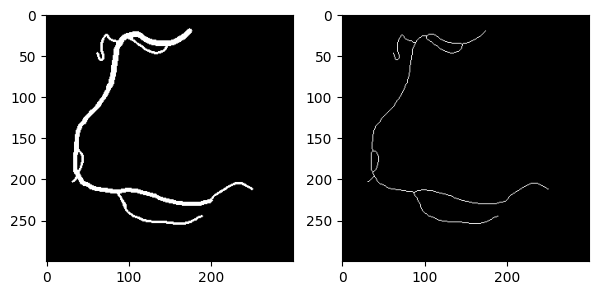

In [11]:
plt.figure(figsize=(7,4))
plt.subplot(1,2,1)
plt.imshow(I, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(skeleton, cmap='gray')
plt.show()

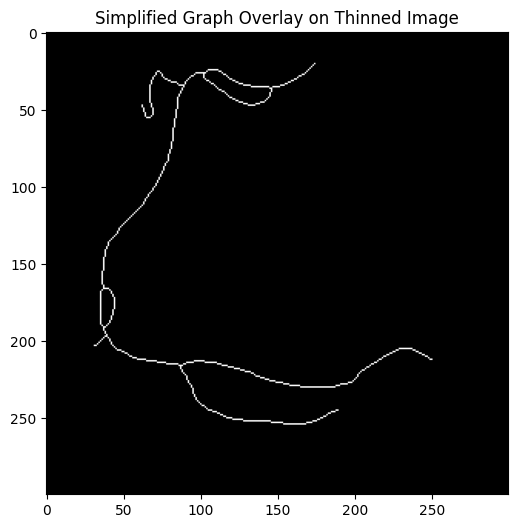

In [12]:
# Define a 3x3 kernel to check neighbors
kernel = np.array([[1, 1, 1],
                   [1, 10, 1], 
                   [1, 1, 1]])

# Convolve the skeleton with the kernel to count neighbors
neighbor_count = convolve(skeleton, kernel, mode="constant", cval=0)

# Identify endpoints (pixels with exactly 2 neighbors)
endpoints = (neighbor_count == 11) & skeleton

# Identify branch points (pixels with 4+ neighbors)
branch_points = (neighbor_count >= 14) & skeleton

# Extract coordinates of key points
endpoints_coords = np.column_stack(np.where(endpoints))
branch_coords = np.column_stack(np.where(branch_points))

# Create a new graph
G = nx.Graph()

# Add key points as nodes
for y, x in np.vstack([endpoints_coords, branch_coords]):
    G.add_node((y, x))

# Find paths between key points
visited = set()

def trace_path(start):
    """ Recursively traces a path until reaching a key point """
    stack = [start]
    path = [start]

    while stack:
        y, x = stack.pop()
        visited.add((y, x))

        # Find 8-connected neighbors
        neighbors = [(y + dy, x + dx) for dy in [-1, 0, 1] for dx in [-1, 0, 1] 
                     if (dy, dx) != (0, 0) and (y + dy, x + dx) in skeleton]
        
        # Remove visited pixels
        neighbors = [p for p in neighbors if p not in visited]

        if len(neighbors) == 1:  # Continue along a line
            stack.append(neighbors[0])
            path.append(neighbors[0])
        else:
            break  # Stop at a branch or endpoint

    return path

# Trace paths between key points
for start in endpoints_coords:
    if tuple(start) not in visited:
        path = trace_path(tuple(start))
        if len(path) > 1:
            for i in range(len(path) - 1):
                G.add_edge(path[i], path[i + 1])

# Plot the result
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(skeleton, cmap="gray")

# Draw nodes (endpoints in green, branch points in red)
nx.draw_networkx_nodes(G, {n: (n[1], n[0]) for n in G.nodes()}, 
                       node_size=30, ax=ax, 
                       node_color=["green" if n in endpoints_coords else "red" for n in G.nodes()])

# Draw edges
nx.draw_networkx_edges(G, {n: (n[1], n[0]) for n in G.nodes()}, ax=ax, edge_color="yellow")

ax.set_title("Simplified Graph Overlay on Thinned Image")
plt.show()